In [95]:
import numpy as np
import pandas as pd
import seaborn as sns
import time
import itertools
from algorithm import constrained_scipy, generate_Abx, constrained_newton, constrained_steepest_descent
from typing import Callable
import matplotlib.pyplot as plt
from case_studies import *
from dask.distributed import Client

client = Client(threads_per_worker=4, n_workers=8)
client

/Users/spicadust/anaconda3/envs/no/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 50558 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:50558/status,
Dashboard: http://127.0.0.1:50558/status,Workers: 8
Total threads: 32,Total memory: 8.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:50559,Workers: 8
Dashboard: http://127.0.0.1:50558/status,Total threads: 32
Started: Just now,Total memory: 8.00 GiB
Comm: tcp://127.0.0.1:50594,Total threads: 4
Dashboard: http://127.0.0.1:50600/status,Memory: 1.00 GiB
Nanny: tcp://127.0.0.1:50562,


In [31]:
def evaluate_method(alg: Callable, f: Callable, df: Callable, Hf: Callable,
                    Abx, max_iter: int, epsilon: float, f_name: str,
                    alg_name: str):
    A, b, x0 = Abx
    start_time = time.time()
    xs, grad_norms, _ = alg(f,
                            df,
                            Hf,
                            A,
                            b,
                            x0,
                            tol=epsilon,
                            max_iter=max_iter)
    end_time = time.time()
    cpu_time = end_time - start_time
    try:
        optimal_x, _, _ = constrained_scipy(f, df, Hf, A, b, x0, epsilon,
                                            max_iter)
    except ValueError:
        optimal_x = np.inf
    step = len(grad_norms)
    error = np.linalg.norm(f(xs[-1]) - f(optimal_x))
    distance = np.linalg.norm(xs[-1] - optimal_x)
    distances = [np.linalg.norm(x - optimal_x) for x in xs]
    return step, error, distance, cpu_time, f_name, alg_name, optimal_x, distances, A.shape, grad_norms


def evaluate(params: list,
             Abxs: list,
             max_iter: int = 500,
             epsilon: float = 1.e-10):

    futures = []
    # results = []
    for (f, df, hf), (alg, name) in params:
        for Abx in Abxs:
            # results.append(
            #     evaluate_method(alg, f, df, hf, Abx, max_iter, epsilon,
            #                     f.__name__, name))
            futures.append(
                client.submit(evaluate_method, alg, f, df, hf, Abx, max_iter,
                              epsilon, f.__name__, name))
    results = client.gather(futures)
    steps, errors, distance, cpu_times, obj_funcs, alg_names, optimal_xs, distances, dimensions, grad_norms = zip(
        *results)
    return pd.DataFrame({
        'step': steps,
        'error': errors,
        'distance': distance,
        'cpu_time': cpu_times,
        'obj_func': obj_funcs,
        'alg_name': alg_names,
        'distances': distances,
        'optimal_x': optimal_xs,
        'dimensions': dimensions,
        'grad_norms': grad_norms
    })

In [32]:
dimensions = [(5, 10), (10, 20), (15, 30), (20, 40)]
num_points = 10


def generate_Abxs(dimensions: list, num_points: int):
    Abxs = []
    for dim in dimensions:
        for _ in range(num_points):
            Abxs.append(generate_Abx(dim[0], dim[1]))
    return Abxs


inputs = generate_Abxs(dimensions, num_points)

ALGORITHMS = [constrained_newton, constrained_steepest_descent]
OBJ_FS = [f1, f3, f4, f5]
METHOD_NAMES = ["Constrained Newton", 'Constrained Steepest Descent']
METRIC_NAMES = ["steps", "error", "distance", "cpu_time"]
DFS = [df1, df3, df4, df5]
HFS = [Hf1, Hf3, Hf4, Hf5]
fs_zip = zip(OBJ_FS, DFS, HFS)
alg_zip = zip(ALGORITHMS, METHOD_NAMES)
params = list(itertools.product(fs_zip, alg_zip))

In [78]:
# len(inputs) = 40
# each size - 10 (A, b, x0) pairs. from size 1 to 4
# each item in inputs is a tuple of (A, b, x0)

40

In [96]:
f1_name = f1.__name__
x_opt(f1_name, 5)

array([0., 0., 0., 0., 0.])

In [98]:
# 40 (A, b x), 4 functions
# size (m,n): (5, 10), (10, 20), (15, 30), (20, 40)
# each size has 10 different A, b, one x_opt for each function
for (A,b,x0) in inputs:
    n = A.shape[1]
    for f in OBJ_FS:
        f_name = f.__name__
        x_optimal = x_opt(f_name, n)
        residue = np.linalg.norm(A @ x_optimal + b)
        print(f.__name__, residue)


f1 1.5665506722551603
f3 1.5665506722551603
f4 1.5878862563005376
f5 1.5665506722551603
f1 1.0875136763119937
f3 1.0875136763119937
f4 1.110475857421946
f5 1.0875136763119937
f1 1.3215839105874028
f3 1.3215839105874028
f4 1.340627304352349
f5 1.3215839105874028
f1 1.0128983699747962
f3 1.0128983699747962
f4 1.0334077785803004
f5 1.0128983699747962
f1 1.3228997358537267
f3 1.3228997358537267
f4 1.3459798421879587
f5 1.3228997358537267
f1 1.2571169037347738
f3 1.2571169037347738
f4 1.2739761740890483
f5 1.2571169037347738
f1 1.0516964363407806
f3 1.0516964363407806
f4 1.0692753332883411
f5 1.0516964363407806
f1 1.0885746535017937
f3 1.0885746535017937
f4 1.1083496664419041
f5 1.0885746535017937
f1 1.3251173892323118
f3 1.3251173892323118
f4 1.347786566949745
f5 1.3251173892323118
f1 1.2071709707422549
f3 1.2071709707422549
f4 1.2264364492261792
f5 1.2071709707422549
f1 1.4171992356808012
f3 1.4171992356808012
f4 1.468655415387648
f5 1.4171992356808012
f1 2.115086976301593
f3 2.1150869763

In [34]:
full_results_df = evaluate(params, inputs, max_iter=1000, epsilon=1.e-7)
full_results_df.to_csv('./maxiter1000_tol1.e-7.csv')

Text(0.5, 1.0, 'steps for different algorithms and objective functions')

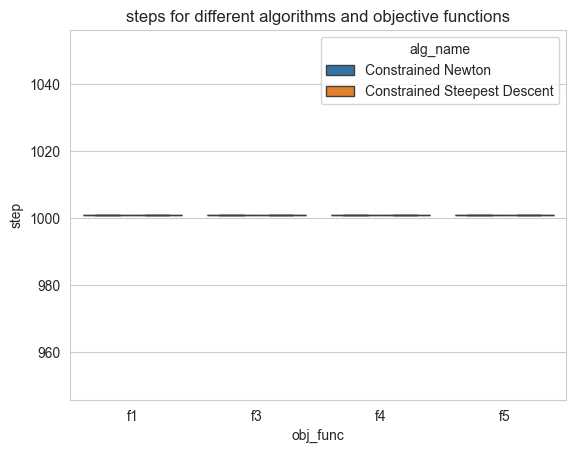

In [9]:
sns.set_style('whitegrid')

sns.boxplot(data=full_results_df,
            x='obj_func',
            y='step',
            hue='alg_name',
            showfliers=False)
plt.title('steps for different algorithms and objective functions')


Text(0.5, 1.0, 'error to the optimal solution')

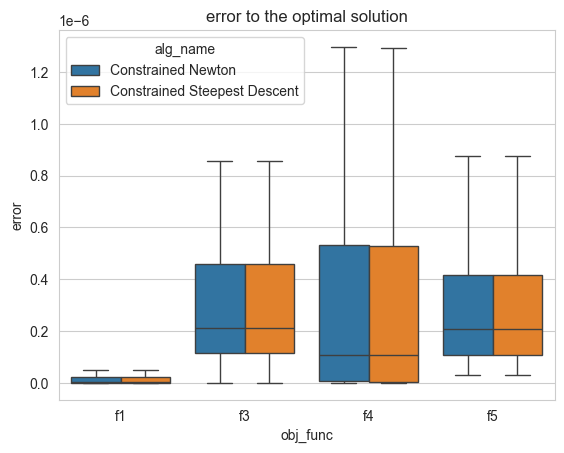

In [47]:
sns.set_style('whitegrid')

sns.boxplot(data=full_results_df,
            x='obj_func',
            y='error',
            hue='alg_name',
            showfliers=False)
plt.title(
    'error to the optimal solution'
)


Text(0.5, 1.0, 'error to the optimal solution')

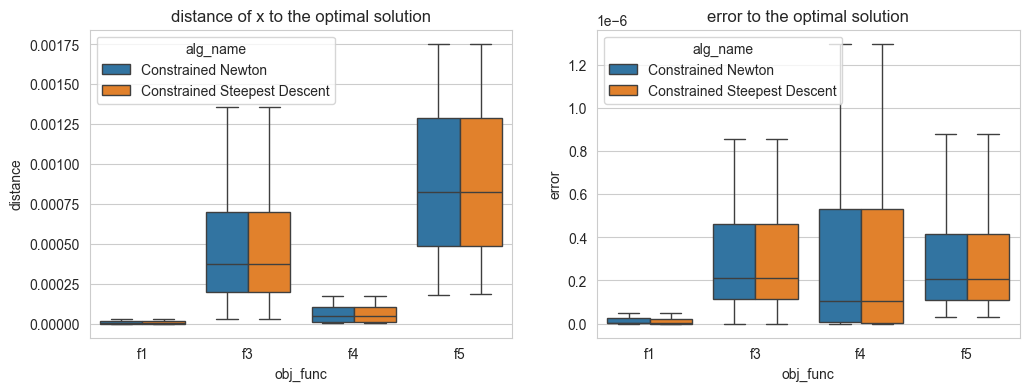

In [52]:
plt.subplots(1, 2, figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.set_style('whitegrid')
sns.boxplot(data=full_results_df,
            x='obj_func',
            y='distance',
            hue='alg_name',
            showfliers=False)
plt.title('distance of x to the optimal solution')
plt.subplot(1, 2, 2)
sns.set_style('whitegrid')
sns.boxplot(data=full_results_df,
            x='obj_func',
            y='error',
            hue='alg_name',
            showfliers=False)
plt.title('error to the optimal solution')


Text(0.5, 1.0, 'cpu time')

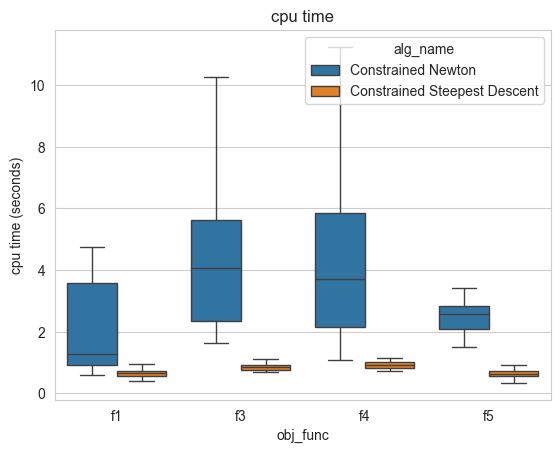

2024-03-08 02:26:58,057 - tornado.application - ERROR - Exception in callback <bound method SystemMonitor.update of <SystemMonitor: cpu: 8 memory: 44 MB fds: 260>>
Traceback (most recent call last):
  File "/Users/spicadust/anaconda3/envs/no/lib/python3.11/site-packages/tornado/ioloop.py", line 919, in _run
    val = self.callback()
          ^^^^^^^^^^^^^^^
  File "/Users/spicadust/anaconda3/envs/no/lib/python3.11/site-packages/distributed/system_monitor.py", line 168, in update
    net_ioc = psutil.net_io_counters()
              ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/spicadust/anaconda3/envs/no/lib/python3.11/site-packages/psutil/__init__.py", line 2117, in net_io_counters
    rawdict = _psplatform.net_io_counters()
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: [Errno 12] Cannot allocate memory
2024-03-08 12:36:07,011 - tornado.application - ERROR - Exception in callback <bound method SystemMonitor.update of <SystemMonitor: cpu: 10 memory: 42 MB fds: 262>>
Traceback (most re

In [59]:
sns.set_style('whitegrid')

sns.boxplot(data=full_results_df,
            x='obj_func',
            y='cpu_time',
            hue='alg_name',
            showfliers=False)
plt.ylabel('cpu time (seconds)')
plt.title('cpu time')


In [35]:
full_results_df

,step,error,distance,cpu_time,obj_func,alg_name,distances,optimal_x,dimensions,grad_norms
0,1001,7.281642e-11,2.944925e-06,2.752078,f1,Constrained Newton,"[6.67495278191758, 2.944924535035505e-06, 2.94...","[-5.677098980263017, 1.8784226516222666, 2.635...","(5, 10)","[1945.8529128570024, 397.8874020781562, 397.88..."
1,1001,3.023558e-09,6.794547e-06,0.636006,f1,Constrained Newton,"[0.46266167682517617, 6.794524931202043e-06, 6...","[-0.04180550192923748, -0.09034603820429267, 0...","(5, 10)","[331.31209688776624, 86.69149762312686, 86.691..."
2,1001,1.239457e-09,5.753728e-06,3.045599,f1,Constrained Newton,"[2.3319113158755282, 5.753727898789629e-06, 5....","[0.7841715777486182, -1.5406781380272758, -1.3...","(5, 10)","[1063.5415590576283, 220.0347388835409, 220.03..."
3,1001,3.085354e-11,4.143244e-09,2.583530,f1,Constrained Newton,"[0.8269716048229528, 4.14324637671541e-09, 4.1...","[0.3201864019803115, -0.6791743854631839, -0.4...","(5, 10)","[520.7597238346843, 30.465258718991127, 30.465..."
4,1001,1.685896e-11,5.613238e-10,0.918017,f1,Constrained Newton,"[0.31944707819714413, 5.639527066085096e-10, 5...","[-0.3495107131898757, -0.34658088642465346, -0...","(5, 10)","[110.50531587207594, 5.809228690425104, 5.8092..."
...,...,...,...,...,...,...,...,...,...,...
315,1001,5.373313e-07,1.587512e-03,0.571364,f5,Constrained Steepest Descent,"[0.37129674945746616, 0.15035687284971264, 0.0...","[0.05640423646256299, -0.07098912761825318, -0...","(20, 40)","[1.1729444302436085, 1.030510552341256, 1.0185..."
316,1001,1.114223e-07,6.639574e-04,0.503524,f5,Constrained Steepest Descent,"[0.37591445282989894, 0.1615612116563513, 0.12...","[-0.012036735640262027, 0.11903804350746562, -...","(20, 40)","[1.4507844620354324, 1.3092955008992813, 1.324..."
317,1001,2.030326e-07,8.255202e-04,0.687229,f5,Constrained Steepest Descent,"[0.4868950944465698, 0.17973503463721455, 0.09...","[-0.02591598855163952, 0.060802454467172216, 0...","(20, 40)","[1.3685544860892012, 1.179198798195963, 1.1527..."
318,1001,1.917848e-07,9.824565e-04,0.554979,f5,Constrained Steepest Descent,"[0.3745685843644545, 0.17809673016217867, 0.11...","[0.05118483044136398, 0.002456024332254694, 0....","(20, 40)","[0.8669702161032822, 0.7187950778691553, 0.700..."


In [43]:
grad_norms = full_results_df['grad_norms'].apply(lambda x: x[-1])
grad_norms.min(), grad_norms.max(), grad_norms.mean(), grad_norms.std()

(0.33971943216264394, 409.1510148689627, 69.5880639567647, 87.02142796109959)

In [41]:
points = []
steps = []
distances = []
dimensions = []
obj_funcs = []
algs = []
grad_norms = []

p_index = 0
for row_dict in full_results_df.to_dict(orient="records"):
    p_indices = [p_index] * len(row_dict['distances'])
    points.extend(p_indices)
    steps += list(range(len(row_dict['distances'])))
    distances.extend(row_dict['distances'])
    dimensions.extend([row_dict['dimensions']] * len(row_dict['distances']))
    obj_funcs.extend([row_dict['obj_func']] * len(row_dict['distances']))
    algs.extend([row_dict['alg_name']] * len(row_dict['distances']))
    grad_norms.extend(row_dict['grad_norms'])
    p_index += 1

flatten_results = pd.DataFrame({
    'points': points,
    'distances': distances,
    'dimensions': dimensions,
    'obj_func': obj_funcs,
    'alg_name': algs,
    'steps': steps, 
    'grad_norms': grad_norms
})

flatten_results

,points,distances,dimensions,obj_func,alg_name,steps,grad_norms
0,0,6.674953,"(5, 10)",f1,Constrained Newton,0,1945.852913
1,0,0.000003,"(5, 10)",f1,Constrained Newton,1,397.887402
2,0,0.000003,"(5, 10)",f1,Constrained Newton,2,397.887402
3,0,0.000003,"(5, 10)",f1,Constrained Newton,3,397.887402
4,0,0.000003,"(5, 10)",f1,Constrained Newton,4,397.887402
...,...,...,...,...,...,...,...
320315,319,0.001060,"(20, 40)",f5,Constrained Steepest Descent,996,0.720661
320316,319,0.001060,"(20, 40)",f5,Constrained Steepest Descent,997,0.720661
320317,319,0.001060,"(20, 40)",f5,Constrained Steepest Descent,998,0.720661
320318,319,0.001060,"(20, 40)",f5,Constrained Steepest Descent,999,0.720661


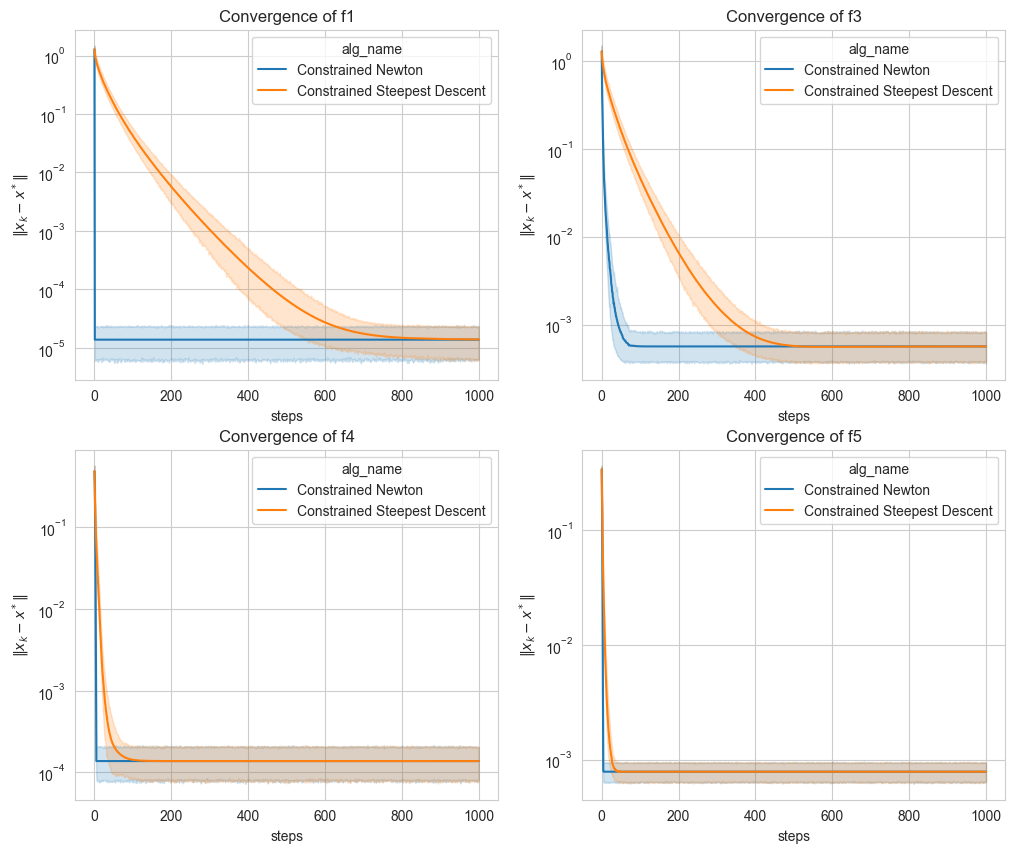

In [26]:
# plt the convergence of f1, f3, f4, f5 respectively
sns.set_style('whitegrid')
plt.subplots(2, 2, figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.lineplot(data=flatten_results[flatten_results['obj_func'] == 'f1'],
             x='steps',
             y='distances',
             hue='alg_name')
plt.title('Convergence of f1')
plt.yscale('log')
plt.ylabel(r'$\|x_k - x^*\|$')


plt.subplot(2, 2, 2)
sns.lineplot(data=flatten_results[flatten_results['obj_func'] == 'f3'],
             x='steps',
             y='distances',
             hue='alg_name')
plt.title('Convergence of f3')
plt.yscale('log')
plt.ylabel(r'$\|x_k - x^*\|$')

plt.subplot(2, 2, 3)
sns.lineplot(data=flatten_results[flatten_results['obj_func'] == 'f4'],
             x='steps',
             y='distances',
             hue='alg_name')
plt.title('Convergence of f4')
plt.yscale('log')
plt.ylabel(r'$\|x_k - x^*\|$')

plt.subplot(2, 2, 4)
sns.lineplot(data=flatten_results[flatten_results['obj_func'] == 'f5'],
             x='steps',
             y='distances',
             hue='alg_name')
plt.title('Convergence of f5')
plt.yscale('log')
plt.ylabel(r'$\|x_k - x^*\|$')

plt.show()

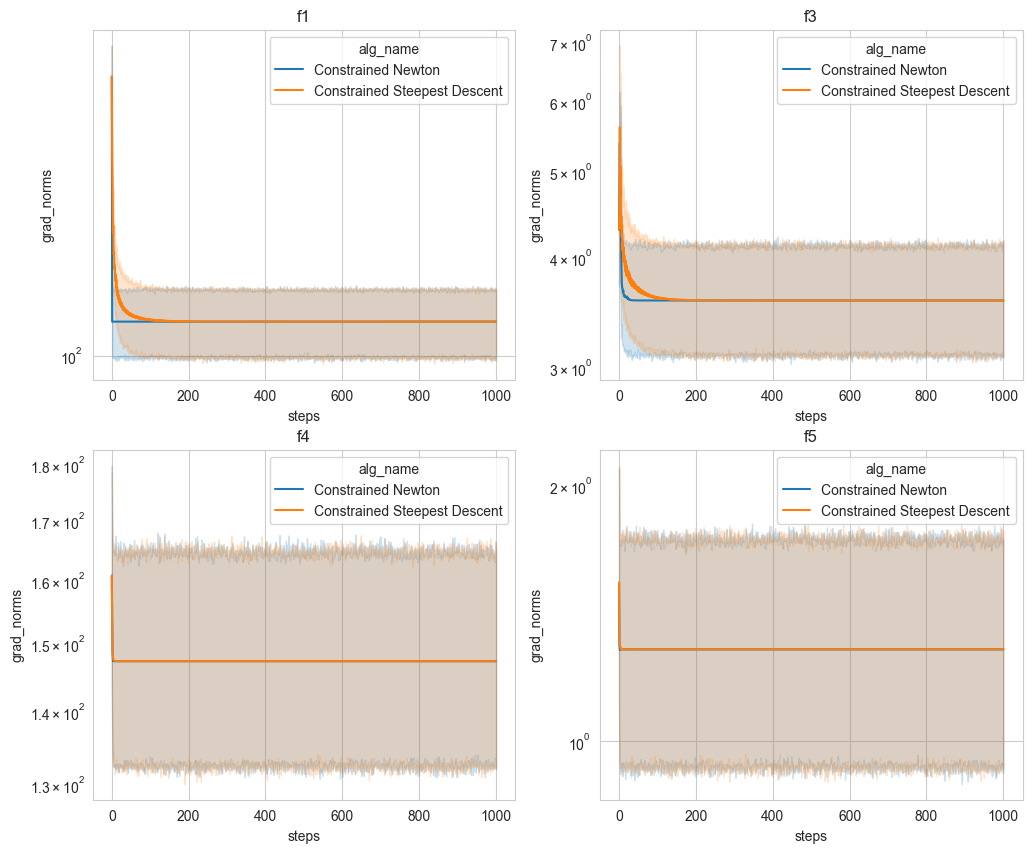

In [56]:
# plt the grad_norms of f1, f3, f4, f5 respectively
sns.set_style('whitegrid')
plt.subplots(2, 2, figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.lineplot(data=flatten_results[flatten_results['obj_func'] == 'f1'],
             x='steps',
             y='grad_norms',
             hue='alg_name')
plt.title('f1')
plt.yscale('log')

plt.subplot(2, 2, 2)
sns.lineplot(data=flatten_results[flatten_results['obj_func'] == 'f3'],
             x='steps',
             y='grad_norms',
             hue='alg_name')
plt.title('f3')
plt.yscale('log')

plt.subplot(2, 2, 3)
sns.lineplot(data=flatten_results[flatten_results['obj_func'] == 'f4'],
             x='steps',
             y='grad_norms',
             hue='alg_name')
plt.title('f4')
plt.yscale('log')

plt.subplot(2, 2, 4)
sns.lineplot(data=flatten_results[flatten_results['obj_func'] == 'f5'],
             x='steps',
             y='grad_norms',
             hue='alg_name')
plt.title('f5')
plt.yscale('log')

plt.show()